In [1]:
#auxiliary functions
library(TableHC)
library(ggplot2)

library(readr)
library(dplyr)
library(tm)
library(tidytext)

library(tidyverse)
library(data.table)
library(SnowballC)
library(readtext)
library(latex2exp)


Warning message:
“package ‘TableHC’ was built under R version 3.5.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ NLP::annotate() masks ggplot2::annotate()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following object is masked from ‘package:purrr’:

    transpose

The following objects are masked from ‘package:dplyr’:

    between, first, last

Warning message:
“package ‘read

<H1> Coefficient of Variance for testing a single document against a single corpus</H1>
The example below use data from PAN2019 contest

In [22]:
dtc = fread('./doc_term_counts_PAN2019_train.csv')
dtc <- dtc %>% filter(!(author %in% '<UNK>')) %>%
                mutate(class = author, term = lemma)

dtc <- dtc %>% filter(!(term %in% c('!', '?', '.', ':', ';','"','`',',','-',"'"))) %>%
                filter(!(POS %in% c('PUNCT', 'PROPN')))


In [9]:
# 
corpus_stat = function(dtc){
    #  mean and std of variance-stable word-frequencies
    dtc %>% ungroup() %>% droplevels() %>%
    select(doc_id, term, n) %>%
    complete(doc_id, term, fill = list(n = 0)) %>%
     mutate(no_docs = n_distinct(dtc$doc_id)) %>%
     group_by(doc_id) %>%
     mutate(T.in_doc = sum(n), r = 2*sqrt(n + 2/8) / sqrt(T.in_doc)) %>%
     ungroup() %>%
     group_by(term) %>%
     group_by(term, no_docs) %>%
     summarize(mu = mean(r), std = sqrt(var(r)), n = sum(n)) %>%
     select(term, no_docs, mu, std, n) %>%
     unique()
    }

two_dtc_stats = function(dtc1, dtc2) {    
    # get binomial P-values in testing the word-frequency tables dtc1 and dtc2
    # arrange dataframe by rank of P-value
    anscomb1 <- corpus_stat(dtc1) %>% filter(n > 2) 
    anscomb2 <- corpus_stat(dtc2) %>% filter(n > 2)

    res <- anscomb1 %>% full_join(anscomb2, by = 'term') %>%
            ungroup() %>%
            fill(no_docs.x, no_docs.y) %>%
            replace(., is.na(.), 0) %>%
            mutate(
              tot.x = sum(n.x),
              tot.y = sum(n.y),
              ) %>%
            rowwise() %>%
            mutate(p = ifelse(n.x + n.y > 0, 
                   binom.test(x = n.x, n = n.x+n.y,
                              p = (tot.x-n.x) / (tot.x + tot.y - n.x - n.y))$p.value,
                   1)) %>%
            arrange(abs(p)) %>%
            mutate(rank = order(p)) %>%
            ungroup()
    res
}    


Select two authors:

In [24]:
dtc$class <- paste(dtc$dataset, dtc$class, sep="_")

In [36]:
lo_classes = unique(dtc$class)

df_smp <- expand.grid(lo_classes, lo_classes) %>% 
          filter(as.vector(Var2) > as.vector(Var1)) %>%
          sample_n(1)

smp = df_smp[1,]

#smp = data_frame(Var1 = c('p05-c01'), Var2 = c('p05-c06')) # Harry potter

#smp$Var1 = 'p02-c08'
#smp$Var2 = 'p04-c09'

dtc1 = dtc %>% filter(class == smp$Var1)
dtc2 = dtc %>% filter(class == smp$Var2)

lo_doc_id = unique(dtc1$doc_id)
lo_doc_id2 = unique(dtc2$doc_id)

print(paste(c("no docs in corpus 1 = ",length(lo_doc_id))))
print(paste(c("no docs in corpus 2 = ",length(lo_doc_id2))))

[1] "no docs in corpus 1 = " "24"                    
[1] "no docs in corpus 2 = " "11"                    


In [47]:
top_rank = 1000
k = 3 # group k docs together to get a more visible effect

dc = sample(lo_doc_id, k) # doc from corpus 1
dc2 = sample(lo_doc_id2, k) # doc from corpus 2

dtc_corpus = dtc1 %>% filter(!(doc_id %in% dc) )
dtc_doc = dtc1 %>% filter(doc_id %in% dc)
dtc_other_corpus = dtc2 %>% filter(!(doc_id %in% dc2) )

stat_within <- two_dtc_stats(dtc_doc, dtc_corpus)
stat_between <- two_dtc_stats(dtc_doc, dtc_other_corpus)

res0 <- stat_within %>%
        filter(rank < top_rank) %>%
        filter(n.y > 4) %>%
        arrange(abs(p)) %>%
        mutate(rank = order(p),
               type = 'concordant',
               nstd = std.y / mu.y) %>%
        select(rank,p,type,nstd,
               std = std.y,
               mu = mu.y
              ) 

p_th = HC.vals(res0$p, stbl = FALSE, alpha = 0.25)$p.star
n_th = sum(res0$p <= p_th)
res0 <- res0 %>% mutate(n_th = n_th, thresh = rank < n_th) 

res1 <- stat_between %>%
        filter(rank < top_rank) %>%
        filter(n.y > 2) %>%
        arrange(abs(p)) %>%
        mutate(rank = order(p),
               type = 'discordant',
               nstd = std.y / mu.y) %>%
        select(rank, type, p, nstd,
               std = std.y,
               mu = mu.y) 

p_th = HC.vals(res1$p, stbl = FALSE, alpha = 0.25)$p.star
n_th = sum(res1$p <= p_th)

res1 <- res1 %>% mutate(n_th = n_th, thresh = rank < n_th)


#between two corpus
res <- two_dtc_stats(dtc1,dtc2) #%>% filter(n.x + n.y > 3)
p_th = HC.vals(res$p, stbl = FALSE, alpha = 0.25)$p.star
n_th = sum(res$p <= p_th)

res <- res %>% mutate(n_th = n_th)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 31 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 32 rows containing missing values (geom_bar).”`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 31 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 32 rows containing missing values (geom_bar).”

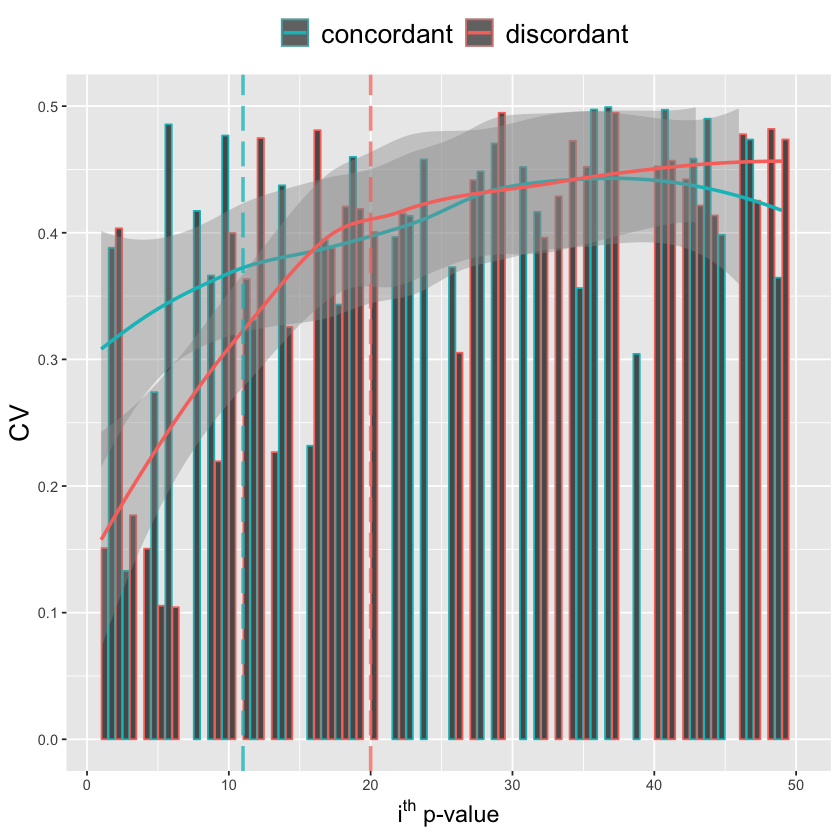

In [50]:
# consider concordant/discordant cases seperately 
top_rank = 50
#path_to_plots = "/Users/kipnisal/Dropbox/Apps//Overleaf/Authorship attribution using Higher Criticism (copy)//Figs/"
path_to_plots = ""


rbind(res0, res1) %>% filter(rank < top_rank) %>%
                ggplot(aes(x = rank, y = std / mu, color = type)) + 
                scale_color_manual(values = c('#00BFC4','#F8766D')) +
               theme(legend.title = element_blank(), legend.position = "top",
              plot.title = element_text(hjust = 0.5, size=16), 
              legend.spacing.x = unit(0.25, 'cm'),
                legend.text=element_text(size=16),
              axis.title.x = element_text(size = 14),
              axis.title.y = element_text(size = 16)
             ) +
                geom_bar(stat = "Identity", width = 1, position = "dodge2") +
                geom_smooth() + xlab(TeX('$i$^{th} p-value')) +
                ylab(TeX("$\\mathrm{CV}$")) + 
                geom_vline(xintercept = c(mean(res0$n_th),mean(res1$n_th)),
                           alpha = 0.75, linetype="longdash",
                           color = c('#00BFC4','#F8766D') , size = 1) +
                xlim(1,top_rank) + ylim(0,0.5) +
                #ggtitle(TeX("$c_v$ versus P-value (single test)")) 
                ggsave(paste(path_to_plots,"nstd_vs_rank_single_bw.png", sep = ''),
                            height = 3.5 , width = 5)


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


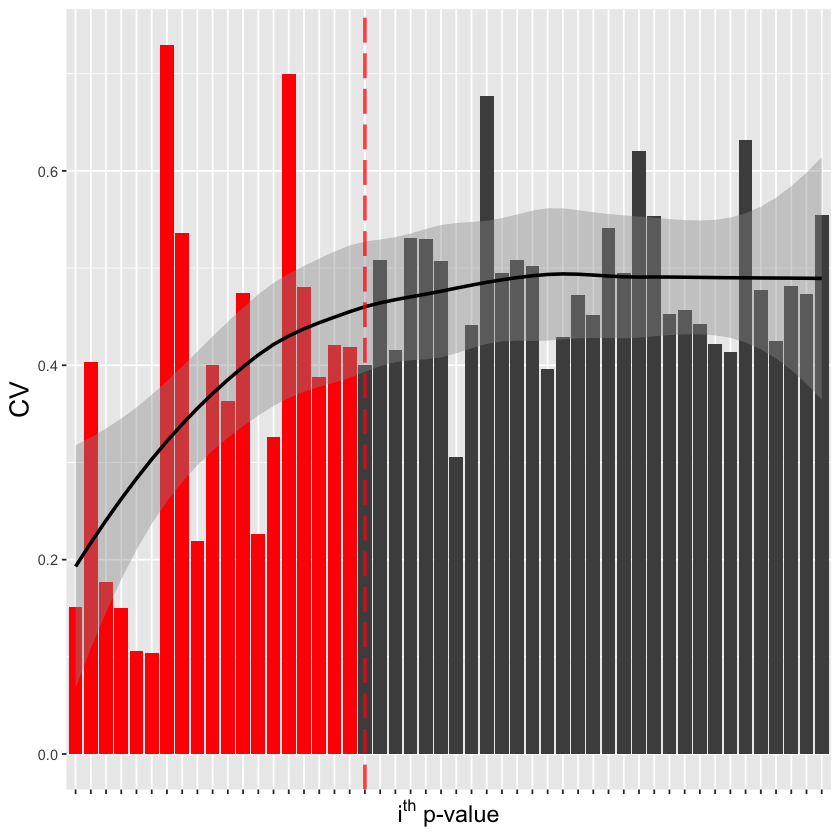

In [51]:
# no concordant/discordant separation
top_rank = 50
res1 %>% mutate(rank = order(rank)) %>%
        mutate(y = std / mu, high_rank = 1.*(rank < res1$n_th[1]) ) %>%
       # filter(n.x > 1, n.y > 1) %>%
        arrange(rank) %>% head(top_rank) %>%
        ggplot(aes(x = reorder(rank, rank), y = y, fill = high_rank, label = rank)) +
        geom_col() +
        scale_fill_gradient(low = 'gray30', high = 'red', name = 'rank') +
        geom_smooth(aes(x = rank, y = y), color="black") +
        geom_vline(xintercept = res1$n_th[1], alpha = 0.75, color = 'red', size = 1, linetype="longdash") +
        xlab(TeX('$i$^{th} p-value')) +
        ylab(TeX('$\\mathrm{CV}$')) +
        theme(plot.title = element_text(hjust = 0.5, size=16), 
              legend.spacing.x = unit(0.25, 'cm'),
                legend.text=element_text(size=16),
              axis.title.x = element_text(size = 14),
              axis.title.y = element_text(size = 16),
              axis.text.x = element_blank(),
              legend.position = "none"
             ) +
        #ggtitle(TeX("$c_v$ ordered according to P-value (single test)")) 
        ggsave(paste(path_to_plots,"nstd_vs_rank_single.png", sep = ''),
                            height = 3.5 , width = 5)


<H1> Coefficient of variance across a single corpus</H1>
The example below uses the 'Federalists' data

In [52]:
#Federalists

# exclude proper names and cardinal numbers
words_to_exclude = c('british', 'pennsylvania', 'york','europe', 'four',
                'three', 'united', 'states', 'new', 'senate', 'republican',
                'president', 'governor', 'congress', 'president', 'congress',
                'britain', 'king', 'american', 'thirteen',
                 'virginia', 'e1', 'ten', 'cabal')

dtc <- fread("doc_term_counts_Federalists.csv")
dataset_name = "Federalists"
dtc$dataset = dataset_name
dtc_disputed <- dtc %>% filter(author %in% c('Disputed'))
dtc <- dtc %>% mutate(doc_id = paper_no, class = author)
dtc <- dtc %>% filter(author %in% c('Hamilton', 'Madison')) %>% 
                filter(!(term %in% words_to_exclude)) %>%
                ungroup()  #only use known federalists paper



In [53]:
author_stat = function(dtc){
    dtc %>% ungroup() %>% droplevels() %>%
    select(doc_id, term, n) %>%
    complete(doc_id, term, fill = list(n = 0)) %>%
     mutate(no_docs = n_distinct(dtc$doc_id)) %>%
     group_by(doc_id) %>%
     mutate(T.in_doc = sum(n), r = 2*sqrt(n + 2/8) / sqrt(T.in_doc)) %>%
     ungroup() %>%
     group_by(term) %>%
     group_by(term, no_docs) %>%
     summarize(mu = mean(r), std = sqrt(var(r)), n = sum(n)) %>%
     select(term, no_docs, mu, std, n) %>%
     unique() %>% ungroup()
    }

In [54]:
lo_cor = unique(dtc$author)

cor = sample(lo_cor,1)
cor = 'Hamilton'

dtc1 <- dtc %>% filter(author == cor)

dtc_stat <- author_stat(dtc1)

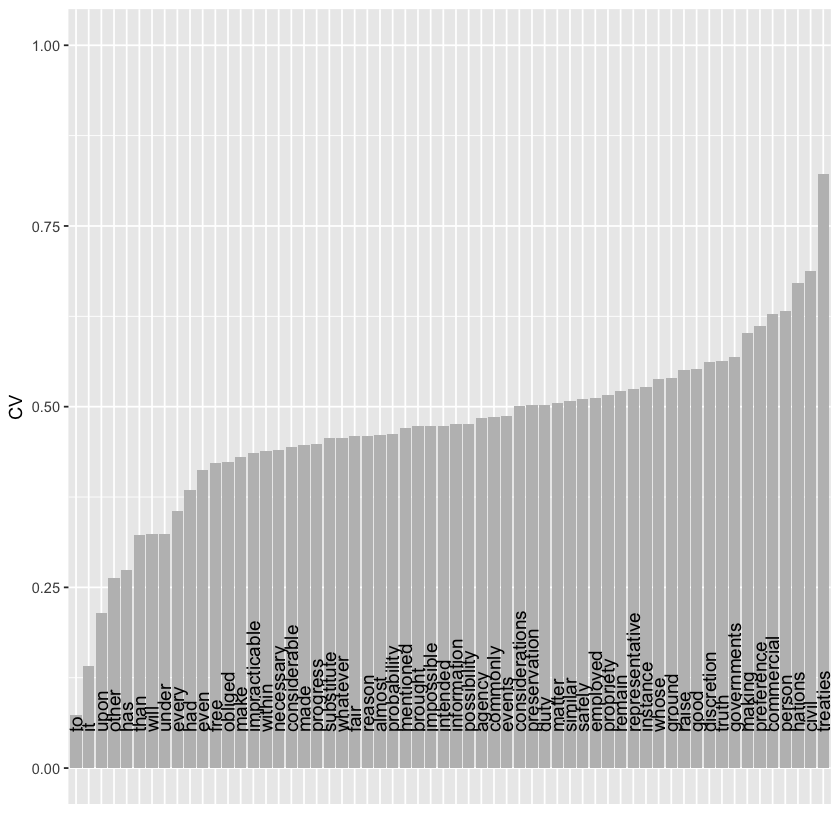

In [55]:
#single corpus null 
path_to_plots = "/Users/kipnisal/Dropbox/Apps//Overleaf/Authorship attribution using Higher Criticism (copy)//Figs/"
#path_to_plots = ""

data_plot <- dtc_stat %>%
        filter(!(term %in% c('fuck','cock','gay','\'s', 'nipple', 'ass','jerk',
                             'cum' ,'british', 'pennsylvania', 'york','clit','two','second','first'))) %>%
        mutate(nstd = std/mu) %>%
        filter(mu > 0.03) %>%
        sample_n(60) 


data_plot %>% ggplot(aes(x = reorder(term, nstd), y = nstd, label = term)) +
        theme(#legend.title = element_text(TeX("$\\mu$")),
              #legend.position = "none",
             plot.title = element_text(hjust = 0.5),
             axis.text.x=element_blank(),
             axis.ticks.x=element_blank()
             ) +
        geom_col(fill ="gray") + 
        geom_text(aes(y = 0.25),
            hjust = 0, nudge_x = 0, nudge_y = -0.2, angle = 90, check_overlap = FALSE,
                               color = 'black', size = 4) +
#        coord_cartesian(xlim = c(0, 700)) +       
        #scale_x_log10() + scale_y_log10() +
        xlab("") + ylab(TeX('$\\mathrm{CV}$')) + ylim(0,1)
        ggsave(paste(path_to_plots,"nstd_bar_single_null.png", sep = ''),
                            height = 3.5 , width = 10)


Warning message:
“Ignoring unknown parameters: check_overlap”

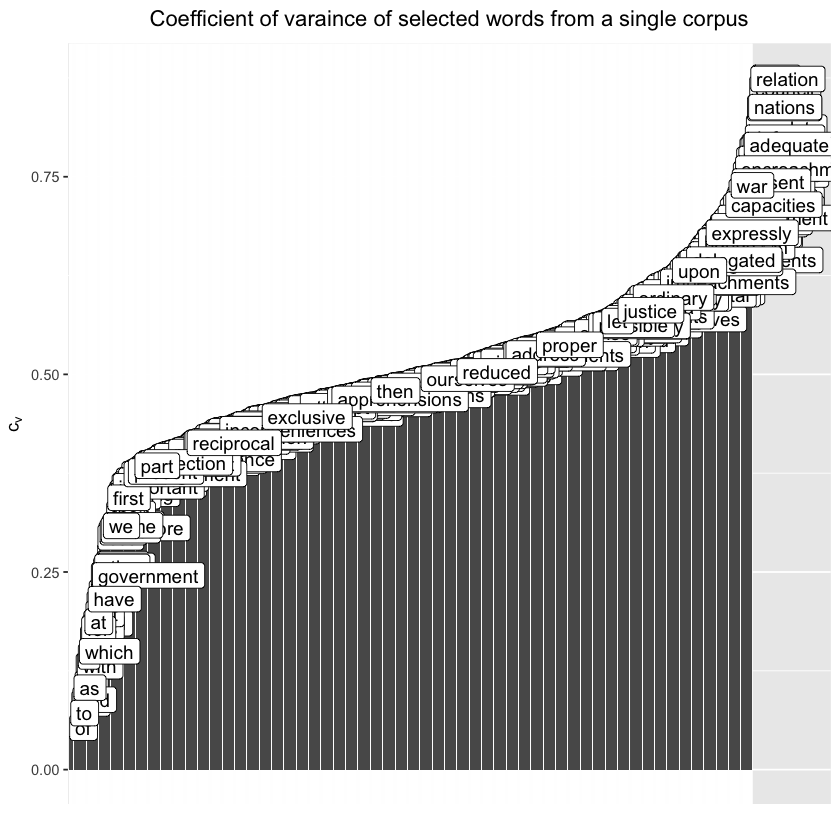

In [24]:
#single corpus null 
#path_to_plots = "/Users/kipnisal/Dropbox/Apps//Overleaf/Authorship attribution using Higher Criticism//Figs/"
path_to_plots = "/Users/kipnisal/Dropbox/Apps//Overleaf/Higher Criticism and Authorship Attribution (presentation)/Figs/"
path_to_plots = ""

data_plot <- res %>% sample_frac(size = 0.5) %>%
        filter(!(term %in% c('fuck','cock','gay','\'s', 'nipple', 'ass','jerk',
                             'cum' ,'british', 'pennsylvania', 'york','clit','two'))) %>%
        mutate(nstd = std.y/mu.y) %>%
        filter(nstd < 0.9) %>%
        select(term, mu = mu.x, std = std.x, evar = evar.x, nstd, p) %>%
        filter(mu > 0.01) 


data_plot %>% ggplot(aes(x = reorder(term, nstd), y = nstd, label = term)) +
#       scale_fill_gradient(low = 'blue', high = 'red', name = TeX("\\mu") ) +
        theme(#legend.title = element_text(TeX("$\\mu$")),
              #legend.position = "none",
             plot.title = element_text(hjust = 0.5),
             axis.text.x=element_blank(),
             axis.ticks.x=element_blank()
             ) +
        #geom_abline(slope = -1, intercept = 0.8, alpha = 0.5) +
        #geom_point(size = 0.3) +
        geom_col() + 
        geom_label(hjust = 0, nudge_x = 0, nudge_y = 0.01, angle = 90, check_overlap = TRUE,
                               color = 'black', size = 4) +
        coord_cartesian(xlim = c(0, 700)) +
        
        #scale_x_log10() + scale_y_log10() +
        ggtitle(TeX("Coefficient of varaince of selected words from a single corpus")) +
        xlab("") + ylab(TeX('$\\mathrm{CV}$')) #+ ylim(0,3.5)
        ggsave(paste(path_to_plots,"nstd_bar_single_null.png", sep = ''),
                            height = 3.5 , width = 7)


<H2>Eye catching illustration of word frequencies</H2>

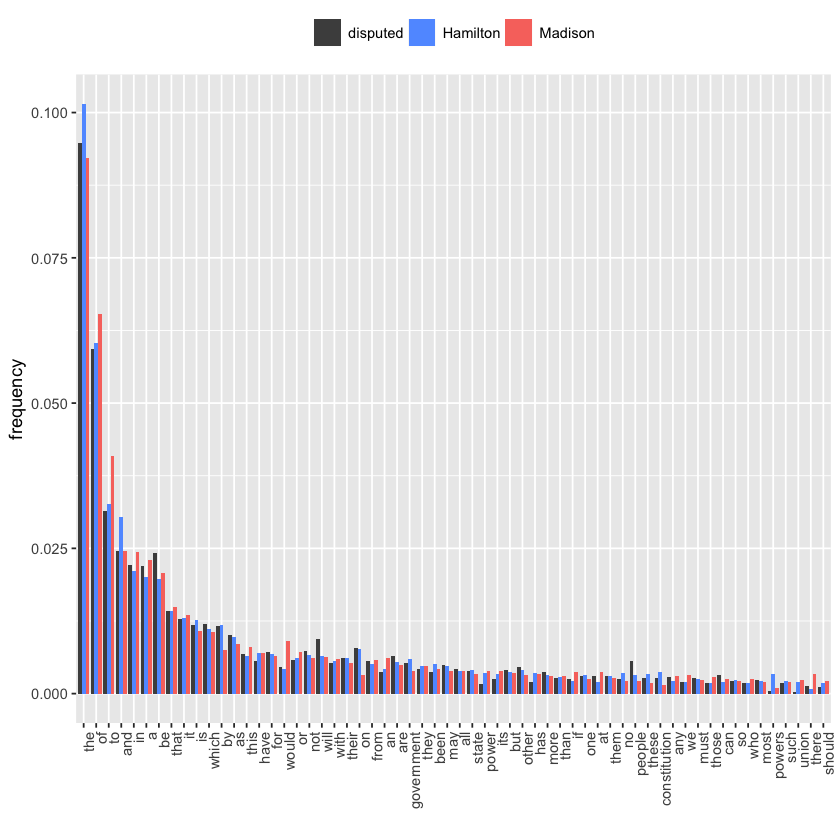

In [21]:

path_to_plots = "/Users/kipnisal/Dropbox/Apps//Overleaf/Authorship attribution using Higher Criticism (copy)//Figs/"
path_to_plots = ""

summarize_dtc = function(dtc){
        dtc %>% 
        group_by(author, term) %>%
        summarise(n = sum(n)) %>%
        ungroup() %>%
        mutate(total = sum(n)) %>%
        unique()
    }


dtc_Mad = summarize_dtc(dtc %>% filter(author == 'Madison'))
dtc_doc = summarize_dtc(dtc_disputed)
dtc_Ham = summarize_dtc(dtc %>% filter(author == 'Hamilton'))

to_disp <- dtc_Ham %>% full_join(dtc_Mad, by = 'term') %>%
            left_join(dtc_doc, by = 'term') %>%
            filter(n>0, n.x > 0, n.y > 0) %>%
            mutate(f.x = n.x / total.x, f.y = n.y / total.y, f = n / total) %>%
     #       sample_frac(size = 0.2) %>%
            arrange(-(f.x+f.y)) %>%
            head(60) 

to_disp %>% transmute('term' = term, ' Madison' = f.x, ' Hamilton' = f.y, ' disputed' = f, 'ord' = order(-(f.x+f.y)) ) %>%
          gather(key = type, value = freq, -term, -ord) %>%
          ggplot(aes(x = reorder(term,ord) , y = freq, fill = type)) +
          geom_bar(stat = "identity", position = "dodge") +
          scale_fill_manual(values = c("grey30","#619CFF", "#F8766D","#00BA38")) + #scale_y_log10() +
         # ggtitle("Word Frequencies") +
          theme(axis.text.x = element_text(angle = 90, hjust = 1),
                legend.title = element_blank(),
                legend.position="top", legend.spacing.x = unit(0.05, 'cm')
               ) + xlab('') +
          ylab('frequency') 
          ggsave(paste(path_to_plots,"word_freq_unk.png", sep = ''),
                                        height = 3 , width = 8)


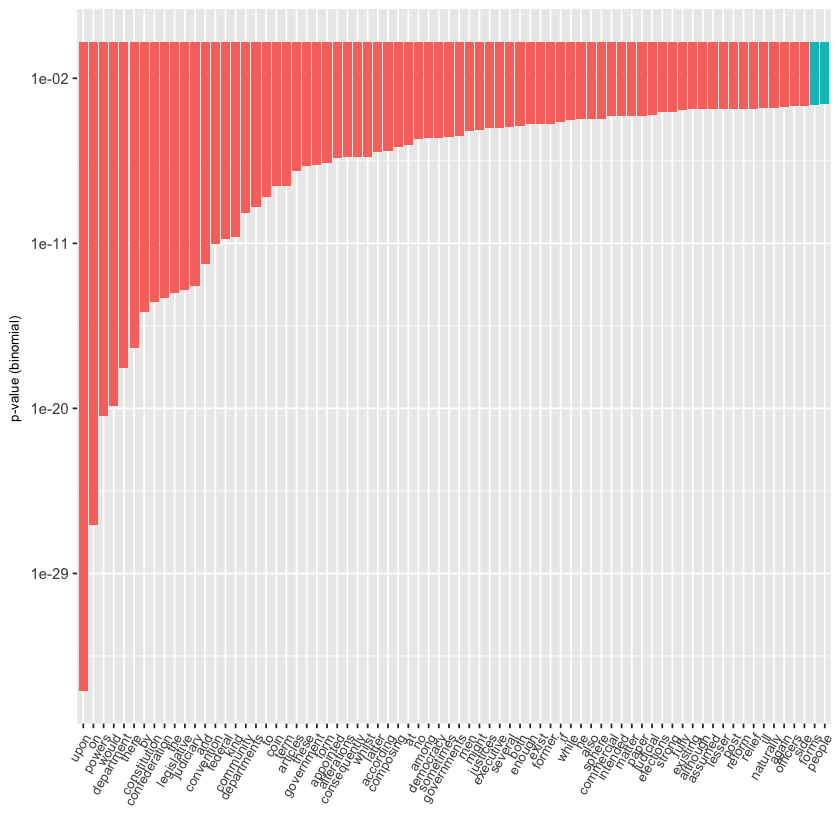

In [22]:
path_to_plots = ""

res %>% mutate(high_rank = rank < n_th) %>% filter(rank < 75) %>% 
    ggplot(aes(x = reorder(term, rank), y = p, fill = !high_rank)) +
    geom_col() + 
    ylab(TeX('$p$-value (binomial)   ')) + xlab("") +
    theme(legend.position = "none", plot.title = element_text(hjust = 0.5)) +
    theme(axis.text=element_text(size=9), axis.text.x = element_text(angle = 60, hjust = 1, size = 8),
          axis.title.y = element_text(size = 8)
         ) + scale_y_log10()
 ggsave(paste(path_to_plots,"selected_words_Federalists.png", sep = ''), height = 2 , width = 8)